# Problem Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. This notebook analyses tweets data collected from tweeter and uses Natural Language Processing techniques to classify whether a tweet is describing a genuine disaster event or is a false positive. 

In [562]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import nltk
import matplotlib.pyplot as plt 
import seaborn as sb 
import re 
import string

In [563]:
train = pd.read_csv("train.csv")
train.shape

(7613, 5)

In [564]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [565]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [566]:
cols_needed= ['id', 'text', 'target']
train = train[cols_needed]
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [567]:
#generate random examples to understand what preprocessing methods might be needed
from random import randint
for i in range(51):
    value = randint(0, 7613)
    print(train["text"][i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...
Three people died from the heat wave so far
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida 

# Text Preprocessing 

We see that lot of sentences has url, html links and emojis in them. Let's try to remove those from the sentences and make them cleaner for interpretation by our algorithm.

In [568]:
def remove_URL(text):
    """
    removes urls from string 
    """
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [569]:
remove_URL("Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw")

'Check these out:     #nsfw'

In [570]:
def remove_emoji(text):
    """
    removes emojis from string
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [571]:
data = u'This is a smiley face \U0001f602'
print(data + '\n' + remove_emoji(data))

This is a smiley face 😂
This is a smiley face 


In [572]:
def remove_html(text):
    """
    removes html links from string
    """
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

In [573]:
def remove_punct(text):
    """
    removes punctuation marks from string 
    """
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [574]:
remove_punct("The end!")

'The end'

In [575]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshalthakker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [576]:
stopwords = stopwords.words('english')
len(stopwords)

179

In [577]:
#since tweets would have tags starting with @. Let's remove those along with the stopwords. 
tags = r"@\w*"

def remove_stopwords(text):
    """
    removes stopwords from string
    """
    text = re.sub(tags, "", text)
    new_text = []
    
    for i in text.split(" "):
        if i not in stopwords:
            new_text.append(i)
    return " ".join(new_text)

In [578]:
remove_stopwords("Ley @John")

'Ley '

In [579]:
#Apply above functions to our dataset 

train['text_clean'] = train['text'].apply(remove_URL)
train['text_clean'] = train['text_clean'].apply(remove_emoji)
train['text_clean'] = train['text_clean'].apply(remove_html)
train['text_clean'] = train['text_clean'].apply(remove_punct)
train['text_clean'] = train['text_clean'].apply(remove_stopwords)
train['text_clean'] = train['text_clean'].apply(lambda x: x.lower())
train.head()

,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds reason earthquake may allah forgive us
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked shelter place notified off...
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...


In [580]:
train.shape

(7613, 4)

Let us first check the out of 7613 training examples, how many of them are actually genuine disaster tweets. If we have imbalance dataset with only few examples of positive disaster tweets, then we might have to use sampling methods to balance the distribution. 

In [581]:
round(pd.DataFrame(train["target"].value_counts()) * 100 / train.shape[0], 2)

,target
0,57.03
1,42.97


Let us now analyze the distribution of the length of the tweet. 

In [583]:
tweet_len = train["text_clean"].apply(len)

(array([ 190.,  502.,  848., 1048., 1387., 1348., 1379.,  713.,  182.,
          16.]),
 array([  5. ,  18.5,  32. ,  45.5,  59. ,  72.5,  86. ,  99.5, 113. ,
        126.5, 140. ]),
 <a list of 10 Patch objects>)

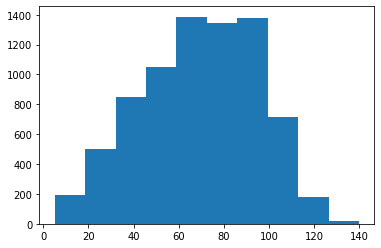

In [584]:
plt.hist(tweet_len)

In [585]:
import transformers

In [586]:
print(transformers.__version__)

4.12.5


In [587]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [588]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [589]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
inputs

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [590]:
inputs["labels"] = tf.reshape(tf.constant(1), (-1, 1)) # Batch size 1

In [591]:
inputs

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>, 'labels': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>}

In [592]:
outputs = model(inputs)
outputs

TFSequenceClassifierOutput(loss=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9603338], dtype=float32)>, logits=<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.30966836, -0.16815984]], dtype=float32)>, hidden_states=None, attentions=None)

In [593]:
loss = outputs.loss
loss

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9603338], dtype=float32)>

In [594]:
outputs.logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.30966836, -0.16815984]], dtype=float32)>

In [595]:
model.summary()

Model: "tf_bert_for_sequence_classification_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_341 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [596]:
from transformers import InputExample, InputFeatures

In [597]:
train.head()

,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds reason earthquake may allah forgive us
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked shelter place notified off...
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...


In [598]:
#Library for Splitting Dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train["text_clean"], train["target"], test_size = 0.05, random_state =41)

In [599]:
df_train = pd.concat([X_train, y_train], axis= 1)
df_train.head()

,text_clean,target
3317,quick shut show take stage evacuate everyone m...,0
6404,suicide bomber kills 15 saudi security site mo...,1
4326,0day bug fully patched os x comes active explo...,0
3911,fizzy sitting regular flood seats one knows,0
3774,smelling bon fire driving makes wanna sitting ...,1


In [600]:
df_test = pd.concat([X_test, y_test], axis= 1)
df_test.head()

,text_clean,target
6887,kids orphanage obviously traumatised,0
3312,us govt refuses evacuate 1000s americans yemen...,1
4687,1130bst traffic a10paris a40 geneva a7 mons a1...,1
3720,by replacing fear unknown curiosity open toû,0
6276,new item pillow covers any size pillow cover g...,0


In [601]:
df_test.shape

(381, 2)

In [602]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN):
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
    return train_InputExamples, validation_InputExamples

In [603]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(df_train, 
                                                                         df_test, 
                                                                         'text_clean', 
                                                                         'target')

In [604]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=140):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [605]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/opt/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [606]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [607]:
model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
452/452 [==============================] - 20719s 46s/step - loss: 0.3869 - accuracy: 0.8362 - val_loss: 0.4135 - val_accuracy: 0.8346
Epoch 2/2
452/452 [==============================] - 13581s 30s/step - loss: 0.2040 - accuracy: 0.9239 - val_loss: 0.7192 - val_accuracy: 0.8084


1. Understand tokenizers and input sequence and other functions 
2. Preprocess data like the Kaggle NB
3. Rerun algo
4. Optimize the algo 

In [608]:
test = pd.read_csv("test.csv")
test = pd.DataFrame(test["text"])
test.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [609]:
test.shape

(3263, 1)

In [610]:
#Apply above functions to our dataset 

test['text'] = test['text'].apply(remove_URL)
test['text'] = test['text'].apply(remove_emoji)
test['text'] = test['text'].apply(remove_html)
test['text'] = test['text'].apply(remove_punct)
test['text'] = test['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(lambda x: x.lower())
test.head()

,text
0,just happened terrible car crash
1,heard earthquake different cities stay safe ev...
2,forest fire spot pond geese fleeing across str...
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills 28 china taiwan


In [611]:
test_list = []
for i in range(len(test)):
    test_list.append(test["text"][i])
    
test_list[0]

'just happened terrible car crash'

In [612]:
test_list[5]

'were shakingits earthquake'

In [613]:
tf_batch = tokenizer(test_list, max_length=140, padding=True, truncation=True, return_tensors='tf')

In [614]:
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)

labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()

In [615]:
label

array([1, 1, 1, ..., 1, 1, 1])

In [617]:
for i in range(len(test_list)):
    print(test_list[i], ": \n", labels[label[i]])

just happened terrible car crash : 
 Positive
heard earthquake different cities stay safe everyone : 
 Positive
forest fire spot pond geese fleeing across street i cannot save : 
 Positive
apocalypse lighting spokane wildfires : 
 Positive
typhoon soudelor kills 28 china taiwan : 
 Positive
were shakingits earthquake : 
 Positive
theyd probably still show life arsenal yesterday eh eh : 
 Negative
hey how : 
 Negative
what nice hat : 
 Negative
fuck : 
 Negative
no i dont like cold : 
 Negative
nooooooooo dont : 
 Negative
no dont tell : 
 Negative
what : 
 Negative
awesome : 
 Negative
birmingham wholesale market ablaze bbc news  fire breaks birminghams wholesale market  : 
 Positive
sunkxssedharry wear shorts race ablaze  : 
 Negative
previouslyondoyintv toke makinwaûªs marriage crisis sets nigerian twitter ablaze  : 
 Positive
check     nsfw : 
 Negative
psa iûªm splitting personalities

 techies follow ablazeco
 burners follow ablaze : 
 Negative
beware world ablaze sierra leone  

 Negative
ûïmaccocktail the first casualty war truth
 hiram johnson died day  tony blairs case died war  : 
 Positive
georgian wines become casualty russias political campaign ukraine  : 
 Negative
bruminthecity oh coffee espresso poss casualty todays busiest thurs ever come perfect coffee  house : 
 Negative
associated agencies inc hiring property  casualty account manager  jobs rollingmeadows insurance : 
 Negative
documenting climate changes first major casualty  via greenharvard  : 
 Positive
canceling deal 2 warships france agrees repay russia via nytimes  : 
 Negative
charlie casualty ashes  : 
 Negative
keep alive sound intensity level catering keeping auditory effect casualty insurance hcxvneoav : 
 Negative
ûï5sosglobalsquad give money hear social casualty live 

mtvhottest 5sosû i 5 buck id give : 
 Negative
vpzedd reach skype : 
 Negative
please read casualty fans
let us know  help spread word retweeting dm scriptettesar info  : 
 Negative
business casualty : 
 Negative


the drowning girl caitlin r kiernan centipede press signed numbered limited  full reû   : 
 Negative
the drowning girl caitlin r kiernan centipede press signed numbered limited  full reû   : 
 Negative
and im drowning in the dìäjìû vuuuuu weve seen it all befoooooooore : 
 Negative
boy saves autistic brother drowning a nineyearold maine dove pool save autistic brother drowning : 
 Positive
boy saves autistic brother drowning a nineyearold maine dove pool save autistic brother drowning : 
 Positive
the drowning girl caitlin r kiernan centipede press signed numbered limited  full reû   : 
 Negative
migrants drowning  erecting monuments 100 years shed tears powerful nations greed letting die : 
 Positive
drowning doesnt sound half bad rn : 
 Negative
boy saves autistic brother drowning newsvideos  : 
 Positive
oh shit dusts storm attack and fidgets bullet thing made some crazy ricochet attack : 
 Positive
the dust storm chase scene pretty damn cool ghostprotocol : 
 Positive
new mad ma

that i would giveû  : 
 Negative
remove  browser hijack  : 
 Negative
i think parents r shit daysonly coz i dont kidsbut let ur child pretend hijacker drives laters : 
 Negative
remove  linkury browser hijacker   : 
 Negative
jagexsupport u remove email hijacker pls  ykjl ign need recover pls block dont break bank pin : 
 Negative
governor allows parole school bus hijacker   sahelnews : 
 Positive
updated friday 430 am  daily area news
california school bus hijacker parole stands  : 
 Positive
governor allows parole school bus hijacker  liveleakfun   : 
 Positive
mch2601 the avi ht realdb4prez16  
he provided artwork years  years great hijacker stories : 
 Negative
remove  linkury browser hijacker   : 
 Negative
the footage albert reynolds talking hijacker demanding publication 3rd secret fatima hilarious : 
 Negative
earnest pletchûªs coldblooded killing carl bivens one chapter strange life   : 
 Positive
hot  funtenna hijacking computers send data sound waves black hat 2015  prebre

 Positive
riot police intervene southampton vitesse arnhem supporters clash û¢ fans clash buildup second legû  : 
 Positive
riot police intervene southampton vitesse arnhem supporters clash û¢ fans clash buildup second  : 
 Positive
shootn video gameswow ghee  sad
but i still dont see rioting walks  : 
 Positive
bhramabull watch run the jewels use facts defend rioting ferguson the socially minded duo takes  : 
 Positive
swear god make faker play kog im rioting : 
 Negative
bhramabull watch run the jewels use facts defend rioting ferguson the socially minded duo takes  : 
 Positive
amiestager theres better alternatives rioting dont kill theyll kill us : 
 Positive
i stopped trying figure this misogynyracismreligionfueled shooting incite rioting : 
 Positive
dont use allahuakbar start rioting do guys even listen shame : 
 Negative
abbydphillip dahboo7 shhits ok puny 13 black population get mad  the gov cant control majority rioting : 
 Positive
foxandfriends protest looting rioting ig

mgs4 came time great upheaval life itûªs odd mgsv coming itûªs also things getting iffy : 
 Negative
bat four reasons en route upheaval versus internet buzz value pvdrdljvc : 
 Negative
  ancient mayan tablet hieroglyphics honors lowly king livescience future û  : 
 Negative
permutable site conspiracy uptotheminute upheaval qwkd : 
 Negative
for this fan 1 upheaval many done garbage show abcnetwork shondarhimes ellenpompeo   : 
 Negative
life needs quality certain sense security being person cant trust cause stress emotional upheaval : 
 Negative
medieval upheaval hardy boys the secret files
franklin w dixon  aladdin  : 
 Negative
this week received sad news friends daughters cancer prognosis this second upheaval  : 
 Positive
this is how retailers intend survive upheaval  retail consumers  : 
 Negative
roxyunkfalls august 4 1915  violent storm strikes city manayunk flooding damage sports  war news : 
 Positive
dramatic video shows plane landing during violent storm  : 
 Positive
hi

In [618]:
tf_outputs[0]

<tf.Tensor: shape=(3263, 2), dtype=float32, numpy=
array([[-3.50126  ,  2.6268466],
       [-3.8519962,  2.8521013],
       [-3.912174 ,  2.934059 ],
       ...,
       [-3.7606912,  2.7988951],
       [-2.571355 ,  2.0131586],
       [-3.2136936,  2.4524853]], dtype=float32)>

In [619]:
label

array([1, 1, 1, ..., 1, 1, 1])

In [620]:
label_df = pd.DataFrame(label)

In [621]:
label_df.columns

RangeIndex(start=0, stop=1, step=1)

In [622]:
label_df.head()

,0
0,1
1,1
2,1
3,1
4,1


In [623]:
label_df.shape

(3263, 1)

In [624]:
test_org = pd.read_csv("test.csv")
test_org.shape

(3263, 4)

In [625]:
test_org.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [626]:
preds = pd.concat([test_org["id"], label_df], axis = 1)

In [627]:
preds.columns = ["id", "target"]

In [628]:
preds.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [630]:
preds["target"].value_counts()

0    1772
1    1491
Name: target, dtype: int64

In [631]:
preds.to_csv('nlp_preds_1223.csv', index= False)

In [632]:
nlp_preds_1222 = pd.read_csv("nlp_preds_1223.csv")
nlp_preds_1222.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
